In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { widht:80% !important; }</style>"))

In [3]:
from config import * 
config_chapter7()
# This is needed to render the plots in this chapter 
from plots.chapter7 import *

Finished!


# Importing Libraries


In [4]:
import numpy as np 
from PIL import Image 


import torch 
import torch.optim as optim 
import torch.nn as nn  
import torch.nn.functional as F 

from torch.utils.data import DataLoader, random_split, TensorDataset 
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, ToPILImage, CenterCrop, RandomResizedCrop 
from torchvision.datasets import ImageFolder 
from torchvision.models import alexnet, resnet18, inception_v3 
from torchvision.models.alexnet import model_urls 

try:
  from torchvision.models.utils import load_state_dict_from_url 
except ImportError:
  from torch.hub import load_state_dict_from_url 


from stepbystep.v3 import StepByStep 
from data_generation.rps import download_rps

# ImageNet Large Scale Visual Recognition Chanllenge (ILSVRC)

## Comparing Artchitectures

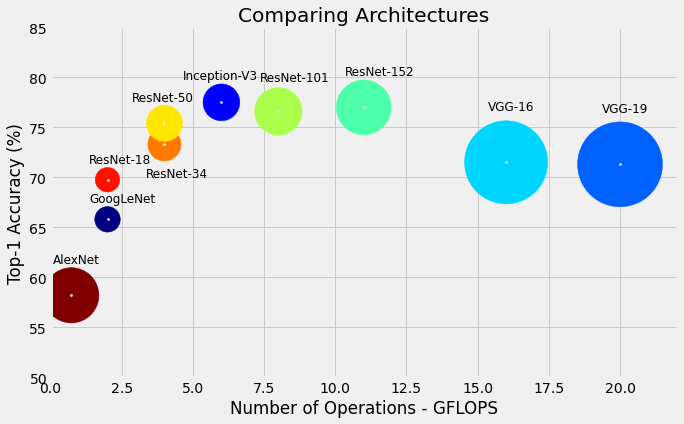

In [5]:
fig = figure1()

# Transfer Learning in Practice

## Pre-Trained Model

In [6]:
alex = alexnet(pretrained=False)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [7]:
print(alex)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

## Adaptive Pooling

In [8]:
result1 = F.adaptive_avg_pool2d(torch.randn(16, 32, 32), output_size=(6, 6))
result2 = F.adaptive_avg_pool2d(torch.randn(16, 12, 12), output_size=(6, 6))
result1.shape, result2.shape

(torch.Size([16, 6, 6]), torch.Size([16, 6, 6]))

## Load Weights

In [9]:
url = model_urls['alexnet']
url

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:253: UserWarning: Accessing the model URLs via the internal dictionary of the module is deprecated since 0.13 and will be removed in 0.15. Please access them via the appropriate Weights Enum instead.
  "Accessing the model URLs via the internal dictionary of the module is deprecated since 0.13 and will "


'https://download.pytorch.org/models/alexnet-owt-7be5be79.pth'

In [10]:
url

'https://download.pytorch.org/models/alexnet-owt-7be5be79.pth'

In [11]:
state_dict = load_state_dict_from_url(url, model_dir='./pretrained', progress=True) 

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to ./pretrained/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [12]:
alex.load_state_dict(state_dict)

<All keys matched successfully>

## Model Freezing

In [13]:
def freeze_model(model):
  for parameter in model.parameters():
    parameter.requires_grad=False

In [14]:
freeze_model(alex)

## Top of the Model

In [15]:
print(alex.classifier)

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


In [16]:
torch.manual_seed(11)
alex.classifier[6] = nn.Linear(4096, 3)

In [17]:
for name, param in alex.named_parameters():
  if param.requires_grad == True:
    print(name)

classifier.6.weight
classifier.6.bias


## Model Configuration

In [18]:
torch.manual_seed(17)
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
optimizer_alex = optim.Adam(alex.parameters(), lr=3e-4)

## Data Preparation

### Rock, Paper, Scissors Dataset

In [19]:
# This may take a couple of minutes......
download_rps() # if you ran it in Chapter 6, it won't do anything else

In [20]:
normalizer = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

composer = Compose([Resize(256), CenterCrop(224), ToTensor(), normalizer])

train_data = ImageFolder(root='rps', transform=composer)
val_data = ImageFolder(root='rps-test-set', transform=composer)

# Builds a loader of each set 
train_loader = DataLoader(train_data, batch_size=16, shuffle=True) 
val_loader = DataLoader(val_data, batch_size=16)

## Model Training

In [21]:
sbs_alex = StepByStep(alex, multi_loss_fn, optimizer_alex)
sbs_alex.set_loaders(train_loader, val_loader)
sbs_alex.train(1)

In [22]:
StepByStep.loader_apply(val_loader, sbs_alex.correct)

tensor([[110, 124],
        [124, 124],
        [124, 124]])

## Generating a Dataset of Features

In [23]:
alex.classifier[6] = nn.Identity()
print(alex.classifier)

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Identity()
)


In [24]:
def preprocessed_dataset(model, loader, device=None):
  if device is None:
    device = next(model.parameters()).device 

  features = None 
  labels = None 

  for i, (x, y) in enumerate(loader):
    model.eval()
    x = x.to(device)
    output = model(x)
    if i == 0:
      features = output.detach().cpu()
      labels = y.cpu()

    else:
      features = torch.cat([features, output.detach().cpu()])
      labels = torch.cat([labels, y.cpu()])

  dataset = TensorDataset(features, labels) 
  return dataset

In [25]:
train_preproc = preprocessed_dataset(alex, train_loader)
val_preproc = preprocessed_dataset(alex, val_loader)

In [26]:
torch.save(train_preproc.tensors, 'rps_preproc.pth')
torch.save(val_preproc.tensors, 'rps_val_preproc.pth')

In [27]:
x, y = torch.load('rps_preproc.pth')
train_preproc = TensorDataset(x, y)
val_preproc = TensorDataset(*torch.load('rps_val_preproc.pth'))

In [28]:
train_preproc_loader = DataLoader(train_preproc, batch_size=6, shuffle=True) 
val_preproc_loader = DataLoader(val_preproc, batch_size=6)

## Top Model

In [29]:
torch.manual_seed(17)
top_model = nn.Sequential(nn.Linear(4096, 3))
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
optimizer_top = optim.Adam(top_model.parameters(), lr=3e-4)

In [30]:
sbs_top = StepByStep(top_model, multi_loss_fn, optimizer_top)
sbs_top.set_loaders(train_preproc_loader, val_preproc_loader)
sbs_top.train(10)

In [31]:
sbs_alex.model.classifier[6] = top_model 
print(sbs_alex.model.classifier)

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Sequential(
    (0): Linear(in_features=4096, out_features=3, bias=True)
  )
)


In [32]:
StepByStep.loader_apply(val_loader, sbs_alex.correct)

tensor([[109, 124],
        [124, 124],
        [124, 124]])

# Auxiliary Classifier (Side-Heads)

In [33]:
model = inception_v3(pretrained=True)
freeze_model(model)

torch.manual_seed(42)
model.AuxLogits.fc = nn.Linear(768, 3)
model.fc = nn.Linear(2048, 3)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

In [34]:
print(model)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [35]:
def inception_loss(outputs, labels):
  try:
    main, aux = outputs 
  except ValueError:
    main = outputs 
    aux = None 
    loss_aux = 0

  multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
  loss_main = multi_loss_fn(main, labels)
  if aux is not None:
    loss_aux = multi_loss_fn(aux, labels)
  return loss_main + 0.4 * loss_aux

In [36]:
optimizer_model = optim.Adam(model.parameters(), lr=3e-4)
sbs_incep = StepByStep(model, inception_loss, optimizer_model)

In [37]:
normalizer = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

composer = Compose([Resize(299), ToTensor(), normalizer])

train_data = ImageFolder(root='rps', transform=composer)
val_data = ImageFolder(root='rps-test-set', transform=composer)

# Builds a loader of each set 
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16)

In [38]:
sbs_incep.set_loaders(train_loader, val_loader)
sbs_incep.train(1)

# 1x1 Convolutions

$$
\Large
\begin{array}
&\text{Filter 1}: -&1& \text{R} &+& 2& \text{G} &+& 0& \text{B}
\\
\text{Filter 2}: &2& \text{R} &+& 0& \text{G} &-& 2& \text{B}
\end{array}
$$

In [39]:
scissors = Image.open('rps/scissors/scissors01-001.png')
image = ToTensor()(scissors)[:3, :, :].view(1, 3, 300, 300)

weights = torch.tensor([0.2126, 0.7152, 0.0722]).view(1, 3, 1, 1)
convolved = F.conv2d(input=image, weight=weights)

converted = ToPILImage()(convolved[0])
grayscale = scissors.convert('L')

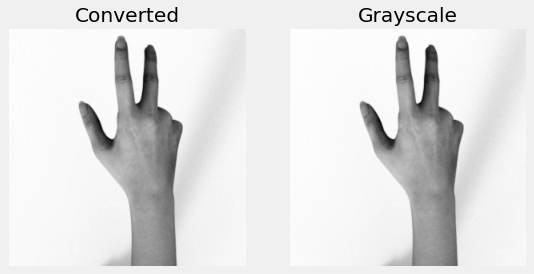

In [40]:
fig = compare_grayscale(converted, grayscale)

# Inception Modules

In [41]:
class Inception(nn.Module):
  def __init__(self, in_channels):
    super(Inception, self).__init__()
    # in_channels@HxW -> 2@HxW
    self.branch1x1_1 = nn.Conv2d(in_channels, 2, kernel_size=1)

    # in_channels@HxW -> 2@HxW -> 3@HxW 
    self.branch5x5_1 = nn.Conv2d(in_channels, 2, kernel_size=1)
    self.branch5x5_2 = nn.Conv2d(2, 3, kernel_size=5, padding=2)

    # in_channels@HxW -> 2@HxW -> 3@HxW
    self.branch3x3_1 = nn.Conv2d(in_channels, 2, kernel_size=1)
    self.branch3x3_2 = nn.Conv2d(2, 3, kernel_size=3, padding=1)

    # in_channel@HxW -> 2@HxW -> 3@HxW
    self.branch_pool_1 = nn.AvgPool2d(kernel_size=3, stride=1, padding=1)
    self.branch_pool_2  = nn.Conv2d(in_channels, 2, kernel_size=1)

  def forward(self, x):
    # Produces 2 channels 
    branch1x1 = self.branch1x1_1(x)
    # Produces 3 channels
    branch5x5 = self.branch5x5_1(x)
    branch5x5 = self.branch5x5_2(branch5x5) 
    # Produces 3 channels 
    branch3x3 = self.branch3x3_1(x)
    branch3x3 = self.branch3x3_2(branch3x3)
    # Produces 2 channels
    branch_pool = self.branch_pool_1(x)
    branch_pool = self.branch_pool_2(branch_pool)
    # Concatenates all channels together (10)
    outputs = torch.cat([branch1x1, branch5x5, branch3x3, branch_pool], 1)
    return outputs


In [42]:
inception = Inception(in_channels=3)
output = inception(image)
output.shape

torch.Size([1, 10, 300, 300])

In [43]:
class BasicConv2d(nn.Module):
  def __init__(self, in_channels, out_channels, **kwargs):
    super(BasicConv2d, self).__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
    self.bn = nn.BatchNorm2d(out_channels, eps=0.01)

  def forward(self, x):
    x = self.conv(x)
    x = self.bn(x)
    return F.relu(x, inplace=True)

# Batch Normalization

$$
\Large
\overline{X} = \frac{1}{n}\sum_{i=1}^n{x_i}
\\
\Large
\sigma(X) = \sqrt{\frac{1}{n}\sum_{i=1}^n{(x_i - \overline{X})^2}}
$$

$$
\Large
\text{standardized }x_i = \frac{x_i-\overline{X}}{\sigma(X)+ \epsilon}
$$

$$
\Large
\text{batch normed }x_i = b + w \text{ standardized }x_i
$$

$$
\Large
\text{batch normed }x_i = \text{standardized }x_i\ \gamma + \beta
$$

## Running Statistics

In [44]:
torch.manual_seed(23)
dummy_points = torch.randn((200, 2)) + torch.rand((200, 2)) * 2
dummy_labels = torch.randint(2, (200, 1))
dummy_dataset = TensorDataset(dummy_points, dummy_labels)
dummy_loader = DataLoader(dummy_dataset, batch_size=64, shuffle=True)

In [45]:
iterator = iter(dummy_loader)
batch1 = next(iterator)
batch2 = next(iterator)
batch3 = next(iterator)

In [46]:
mean1, var1 = batch1[0].mean(axis=0), batch1[0].var(axis=0)
mean1, var1

(tensor([0.9850, 1.0381]), tensor([1.4802, 1.1832]))

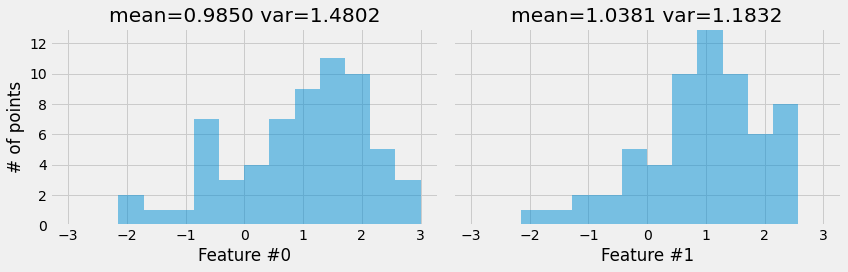

In [47]:
fig = before_batchnorm(batch1)

In [48]:
batch_normalizer = nn.BatchNorm1d(num_features=2, affine=False, momentum=None)
batch_normalizer.state_dict()

OrderedDict([('running_mean', tensor([0., 0.])),
             ('running_var', tensor([1., 1.])),
             ('num_batches_tracked', tensor(0))])

In [49]:
normed1 = batch_normalizer(batch1[0])
batch_normalizer.state_dict()

OrderedDict([('running_mean', tensor([0.9850, 1.0381])),
             ('running_var', tensor([1.4802, 1.1832])),
             ('num_batches_tracked', tensor(1))])

In [50]:
normed1.mean(axis=0), normed1.var(axis=0)

(tensor([6.7055e-08, 1.4435e-07]), tensor([1.0159, 1.0159]))

$$
\Large
\begin{aligned}
\text{Biased Var}(X) &= \frac{1}{n} &\sum_{i=1}^n{(x_i - \overline{X})^2}
\\
\text{Var}(X) &= \frac{1}{n-1} &\sum_{i=1}^n{(x_i - \overline{X})^2}
\end{aligned}
$$

In [51]:
normed1.var(axis=0, unbiased=False)

tensor([1.0000, 1.0000])

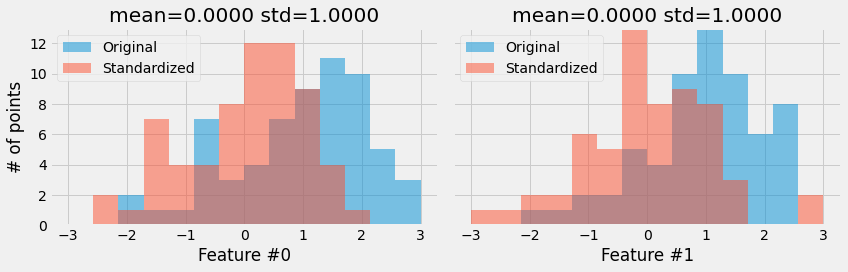

In [52]:
fig = after_batchnorm(batch1, normed1)

In [53]:
normed2 = batch_normalizer(batch2[0])
batch_normalizer.state_dict()

OrderedDict([('running_mean', tensor([0.9611, 0.9964])),
             ('running_var', tensor([1.4247, 1.0460])),
             ('num_batches_tracked', tensor(2))])

In [54]:
mean2, var2 = batch2[0].mean(axis=0), batch2[0].var(axis=0)
running_mean, running_var = (mean1 + mean2) / 2, (var1 + var2) / 2
running_mean, running_var 

(tensor([0.9611, 0.9964]), tensor([1.4247, 1.0460]))

## Evaluation Phase

In [55]:
batch_normalizer.eval()
normed3 = batch_normalizer(batch3[0])
normed3.mean(axis=0), normed3.var(axis=0, unbiased=False)

(tensor([-0.0201,  0.2208]), tensor([0.7170, 1.0761]))

## Momentum

$$
\large
\begin{array}
& \text{EWMA}_t(\alpha, x) &= &\alpha &x_t &+ &(1-\alpha) &\text{EWMA}_{t-1}(\alpha, x)
\\
\text{running stat}_t &= &\text{"momentum"} &\text{stat}_t &+ &(1-\text{"momentum"}) &\text{running stat}_{t-1}
\end{array}
$$

In [56]:
batch_normalizer_mom = nn.BatchNorm1d(num_features=2, affine=False, momentum=0.1)
batch_normalizer_mom.state_dict()

OrderedDict([('running_mean', tensor([0., 0.])),
             ('running_var', tensor([1., 1.])),
             ('num_batches_tracked', tensor(0))])

In [57]:
normed1_mom = batch_normalizer_mom(batch1[0])
batch_normalizer_mom.state_dict()

OrderedDict([('running_mean', tensor([0.0985, 0.1038])),
             ('running_var', tensor([1.0480, 1.0183])),
             ('num_batches_tracked', tensor(1))])

In [58]:
running_mean = torch.zeros((1, 2))
running_mean = 0.1 * batch1[0].mean(axis=0) + (1 - 0.1) * running_mean 
running_mean

tensor([[0.0985, 0.1038]])

## BatchNorm2d

In [59]:
torch.manual_seed(39)
dummy_images = torch.rand((200, 3, 10, 10))
dummy_labels = torch.randint(2, (200, 1))
dummy_dataset = TensorDataset(dummy_images, dummy_labels)
dummy_loader = DataLoader(dummy_dataset, batch_size=64, shuffle=True)

iterator = iter(dummy_loader) 
batch1 = next(iterator)
batch1[0].shape

torch.Size([64, 3, 10, 10])

In [60]:
batch_normalizer = nn.BatchNorm2d(num_features=3, affine=False, momentum=None)
normed1 = batch_normalizer(batch1[0])
normed1.mean(axis=[0, 2, 3]), normed1.var(axis=[0, 2, 3], unbiased=False)

(tensor([ 2.3283e-08, -2.3693e-08,  8.8960e-08]),
 tensor([0.9999, 0.9999, 0.9999]))

# Residual Connections

## Learning the Identity

In [61]:
torch.manual_seed(23)
dummy_points = torch.randn((100, 1))
dummy_dataset = TensorDataset(dummy_points, dummy_points)
dummy_loader = DataLoader(dummy_dataset, batch_size=16, shuffle=True)

In [62]:
class Dummy(nn.Module):
  def __init__(self):
    super(Dummy, self).__init__()
    self.linear = nn.Linear(1, 1)
    self.activation = nn.ReLU()

  def forward(self, x):
    out = self.linear(x)
    out = self.activation(out)
    return out


In [63]:
torch.manual_seed(555)
dummy_model = Dummy()
dummy_loss_fn = nn.MSELoss()
dummy_optimizer = optim.SGD(dummy_model.parameters(), lr=0.1)

In [64]:
dummy_sbs = StepByStep(dummy_model, dummy_loss_fn, dummy_optimizer)
dummy_sbs.set_loaders(dummy_loader)
dummy_sbs.train(200)

In [65]:
np.concatenate([dummy_points[:5].numpy(), dummy_sbs.predict(dummy_points)[:5]], axis=1)

array([[-0.9012059 ,  0.        ],
       [ 0.56559485,  0.56559485],
       [-0.48822638,  0.        ],
       [ 0.75069577,  0.75069577],
       [ 0.58925384,  0.58925384]], dtype=float32)

In [66]:
class DummyResidual(nn.Module):
  def __init__(self):
    super(DummyResidual, self).__init__()
    self.linear = nn.Linear(1, 1)
    self.activation = nn.ReLU()

  def forward(self, x):
    identity = x
    out = self.linear(x)
    out = self.activation(out)
    out = out + identity 
    return out


In [67]:
torch.manual_seed(555)
dummy_model = DummyResidual()
dummy_loss_fn = nn.MSELoss()
dummy_optimizer = optim.SGD(dummy_model.parameters(), lr=0.1)
dummy_sbs = StepByStep(dummy_model, dummy_loss_fn, dummy_optimizer)
dummy_sbs.set_loaders(dummy_loader)
dummy_sbs.train(100)

In [68]:
np.concatenate([dummy_points[:5].numpy(), dummy_sbs.predict(dummy_points)[:5]], axis=1)

array([[-0.9012059 , -0.9012059 ],
       [ 0.56559485,  0.56559485],
       [-0.48822638, -0.48822638],
       [ 0.75069577,  0.75069577],
       [ 0.58925384,  0.58925384]], dtype=float32)

In [69]:
dummy_model.state_dict()

OrderedDict([('linear.weight', tensor([[0.1490]], device='cuda:0')),
             ('linear.bias', tensor([-0.3329], device='cuda:0'))])

In [70]:
dummy_points.max()

tensor(2.2347)

## Residual Blocks

In [73]:
class ResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels, stride=1, skip=True):
    super(ResidualBlock, self).__init__()
    self.skip = skip 

    self.conv1 = nn.Conv2d(
        in_channels, out_channels, 
        kernel_size=3, padding=1, stride=stride,
        bias=False
    )

    self.bn1 = nn.BatchNorm2d(out_channels)
    self.relu = nn.ReLU(inplace=True)

    self.conv2 = nn.Conv2d(
        out_channels, out_channels,
        kernel_size=3, padding=1,
        bias=False
    )

    self.bn2 = nn.BatchNorm2d(out_channels)

    self.downsample = None
    if out_channels != in_channels:
      self.downsample = nn.Conv2d(
          in_channels, out_channels, 
          kernel_size=1, stride=stride
      )

  def forward(self, x):
    identity = x
    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)

    out = self.conv2(out)
    out = self.bn2(out)

    if self.skip:
      if self.downsample is not None:
        identity = self.downsample(identity)
      out = out + identity

    out = self.relu(out)
    return out 

In [74]:
scissors = Image.open('rps/scissors/scissors01-001.png')
image = ToTensor()(scissors)[:3, :, :].view(1, 3, 300, 300)
seed = 14
torch.manual_seed(seed)
skip_image = ResidualBlock(3, 3)(image)
skip_image = ToPILImage()(skip_image[0])


torch.manual_seed(seed)
noskip_image = ResidualBlock(3, 3, skip=False)(image)
noskip_image = ToPILImage()(noskip_image[0])

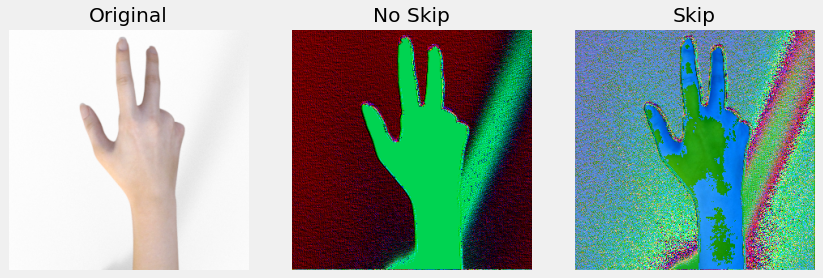

In [75]:
fig = compare_skip(scissors, noskip_image, skip_image)

# Putting It All Together

In [77]:
# ImageNet Statistics
normalizer = Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])

composer = Compose([Resize(256), 
                    CenterCrop(224),
                    ToTensor(),
                    normalizer])


train_data = ImageFolder(root='rps', transform=composer)
val_data = ImageFolder(root='rps-test-set', transform=composer)

# Builds a loader of each set 
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16)

## Fine-tuning

In [78]:
model = resnet18(pretrained=True)
torch.manual_seed(42)
model.fc = nn.Linear(512, 3)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [79]:
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
optimizer_model = optim.Adam(model.parameters(), lr=3e-4)
sbs_transfer = StepByStep(model, multi_loss_fn, optimizer_model)

In [80]:
sbs_transfer.set_loaders(train_loader, val_loader)
sbs_transfer.train(1)

In [81]:
sbs_transfer.loader_apply(val_loader, sbs_transfer.correct)

tensor([[124, 124],
        [124, 124],
        [124, 124]])

## Feature Extraction

In [82]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = resnet18(pretrained=True).to(device)
model.fc = nn.Identity()
freeze_model(model)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [83]:
train_preproc = preprocessed_dataset(model, train_loader)
val_preproc = preprocessed_dataset(model, val_loader) 
train_preproc_loader = DataLoader(train_preproc, batch_size=16, shuffle=True)
val_preproc_loader = DataLoader(val_preproc, batch_size=16)

In [84]:
torch.manual_seed(42)
top_model = nn.Sequential(nn.Linear(512, 3))
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
optimizer_top = optim.Adam(top_model.parameters(), lr=3e-4)

In [85]:
sbs_top = StepByStep(top_model, multi_loss_fn, optimizer_top)
sbs_top.set_loaders(train_preproc_loader, val_preproc_loader)
sbs_top.train(10)

In [87]:
StepByStep.loader_apply(val_preproc_loader, sbs_top.correct)

tensor([[ 98, 124],
        [124, 124],
        [104, 124]])

In [88]:
model.fc = top_model 
sbs_temp = StepByStep(model, None, None)

In [89]:
StepByStep.loader_apply(val_loader, sbs_temp.correct)

tensor([[ 98, 124],
        [124, 124],
        [104, 124]])